# Introduction

[*Critical Role*](https://en.wikipedia.org/wiki/Critical_Role) is "a show where a bunch of nerdy-ass voice actors play [*Dungeons and Dragons*](https://en.wikipedia.org/wiki/Dungeons_%26_Dragons)". CritRoleStats is a group of enthusiasts from the community that track and analyze different events of the game. In this project, I am going to explore their [*All Rolls - Tal'Dorei*](https://docs.google.com/spreadsheets/d/1OEg29XbL_YpO0m5JrLQpOPYTnxVsIg8iP67EYUrtRJg/edit?usp=sharing) table &mdash; a table of dice rolls for the whole Tal'Dorei campaign.

Note: I already have quite a bit of familiarity with the data because a) I am a fan of the show, b) I've spent a long time cleaning up the table as a part of this project. Code for the cleanup can be viewed [here](https://nbviewer.jupyter.org/github/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei.ipynb) and can be downloaded [here](https://github.com/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei.ipynb). The cleaned-up table is [here](https://github.com/onishchenkoar/dungeons-and-dragons-and-probabilities/blob/main/Cleanup_All_Rolls_TalDorei/Cleanish_All_Rolls_TalDorei.xlsx).

# Imports

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns


sns.set()
pd.set_option('display.max_rows', 15000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', 500)

# Initializing a DataFrame

In [ ]:
df = pd.read_excel('drive/MyDrive/Cleanish_All_Rolls_TalDorei.xlsx'
                   , sheet_name='All Episodes')

# Make uncertain rolls certain; replace rolls for fun with 'Other'.
df['Type of Roll'].replace({'Alchemy?' : 'Alchemy',
                            'Arcana?' : 'Arcana',
                            'Athletics/Acrobatics' : 'Athletics',                           
                            'Persuasion?' : 'Persuasion',
                            'Wisdom Save?' : 'Wisdom Save',

                            'Disappointment' : 'Other',
                            'Determine Focus' : 'Other',
                            'Disguise Kit' : 'Other',
                            'Fart.' : 'Other',
                            'Panic' : 'Other',
                            'Test Roll' : 'Other',                           
                            'Trajectory' : 'Other',
                            'Unknown' : 'Other',
                            np.nan : 'Other',
                            }
                           , inplace=True
                          )

df['Total Value'] = df['Total Value'].fillna('Unknown')
df['Natural Value'] = df['Natural Value'].fillna('Unknown')
df['Character'] = df['Character'].fillna('Other')
df['Crit?'] = df['Crit?'].fillna('N')

IN_ORDER = [str(i) for i in range(1, 21)] + ['Unknown']

# Basic information on columns

In [ ]:
df.head()

,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,# Kills,Notes
0,C1E001,0:37:53,Vex'ahlia,Intelligence,20,18,N,NaN,NaN,FIRST ROLL OMG
1,C1E001,0:41:48,Grog,Persuasion,19,18,N,NaN,NaN,NaN
2,C1E001,0:43:25,Keyleth,Persuasion,2,2,N,NaN,NaN,NaN
3,C1E001,0:46:35,Tiberius,Persuasion,12,3,N,NaN,NaN,Disregarded due to advantage
4,C1E001,0:46:35,Tiberius,Persuasion,27,18,N,NaN,NaN,With advantage


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13505 entries, 0 to 13504
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Episode        13505 non-null  object 
 1   Time           13505 non-null  object 
 2   Character      13505 non-null  object 
 3   Type of Roll   13505 non-null  object 
 4   Total Value    13505 non-null  object 
 5   Natural Value  13505 non-null  object 
 6   Crit?          13505 non-null  object 
 7   Damage         2657 non-null   object 
 8   # Kills        340 non-null    float64
 9   Notes          7001 non-null   object 
dtypes: float64(1), object(9)
memory usage: 1.0+ MB


Columns:
1. **Episode** &mdash; id of an episode in which a roll happens. Categorical.
1. **Time** &mdash; timestamp of the roll. Continuous; represented as a string 'HH:MM:SS'.
1. **Character** &mdash; in-game name of the character who makes the roll. Categorical.
1. **Type of Roll** &mdash; an action on which a random decision is needed. For example, Attack, Persuasion, or Deception. Categorical.
1. **Total Value** &mdash; Natural Value + all bonuses the character has during the action. Mixed type: continuous values when known, empty or 'Unknown' otherwise. 
1. **Natural Value** &mdash; a value given by the dice. In a d20 (20-sided die) roll, often, 20 means automatic success, 1 means automatic failure (regardless of the total value). Mixed type: continuous values when known, empty or 'Unknown' otherwise. 
1. **Crit?** &mdash; whether a critical hit rolled (natural 20 on an Attack roll). Categorical: either 'Y' or empty.
1. **Damage** &mdash; value of damage of an attack and its target's name. I think these should be in two separate columns, but I prefer to just ignore this column. Mixed type.
1. **# Kills** &mdash; number of targets killed by an attack. Continuous.
1. **Notes** &mdash; some information about the roll.

# Some memory optimization

Pandas' default way of assigning data types to columns is fairly unsophisticated. Let's try changing the types.

In [ ]:
# Total memory usage (in bytes) by the dataframe:
memory_before = df.memory_usage(deep=True).sum()
print(memory_before)

7356708


In [ ]:
# Number of unique values by column: 
df.nunique()

Episode           117
Time             7624
Character          28
Type of Roll       60
Total Value       102
Natural Value      30
Crit?               2
Damage           2414
# Kills            10
Notes            2200
dtype: int64

I'm changing datatypes of columns with low cardinality to categorical and the single float64 to float32.

In [ ]:
# Change to unordered categorical type:
df['Character'] = df['Character'].astype('category')
df['Type of Roll'] = df['Type of Roll'].astype('category')
df['Crit?'] = df['Crit?'].astype('category')
df['Total Value'] = df['Total Value'].astype('category')

# Change to ordered categorical type:
ordered_eps_type = CategoricalDtype(categories=sorted(df['Episode'].unique())
                                    , ordered=True
                                   )
df['Episode'] = df['Episode'].astype(ordered_eps_type)

ordered_natval_type = CategoricalDtype(categories=IN_ORDER
                                       , ordered=True
                                      )
df['Natural Value'] = df['Natural Value'].astype(ordered_natval_type)

# float64 to float32:
df['# Kills'] = df['# Kills'].astype(np.float32)

In [ ]:
memory_after = df.memory_usage(deep=True).sum()
print(memory_after)

2379562


In [ ]:
memory_after / memory_before

0.32345473002326586

Decreased threefold, nice.

# Simple descriptive statistics

In [ ]:
print(f'Total rows: {len(df)}\n')
df.drop('# Kills', axis=1).describe()

Total rows: 13505



,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,Notes
count,13505,13505,13505,13505,13505,13429,13505,2657,7001
unique,117,7624,28,60,102,21,2,2414,2200
top,C1E114,1:30:00,Vax'ildan,Attack,Unknown,Unknown,N,6 to Kern,Disregarded due to advantage
freq,334,16,2490,3149,1918,4581,13197,13,995


You can make several conclusions from this:
1. The most action-packed episode is 114 &mdash; this is the fight with the final boss.
2. The most active character in the campaign (in terms of rolls, at least) is Vax'ildan.
3. Attack is the most popular type of roll.
4. A lot of roll values are unknown.

In [ ]:
df['# Kills'].describe()

count    340.000000
mean       1.338235
std        1.949282
min        0.500000
25%        1.000000
50%        1.000000
75%        1.000000
max       30.000000
Name: # Kills, dtype: float64

The majority of attacks kill just one target.

# Most and least action-heavy episodes

In [ ]:
# Some rolls go in pairs: you disregard one and keep the other.
# If I filter the disregarded ones out, I get closer to the actual number of events.
is_disregarded = df['Notes'].str.contains('isregard').fillna(False)
action = (df.loc[~is_disregarded, ['Episode', 'Type of Roll']]
            .replace('C1E031 p1', 'C1E031')
            .replace('C1E031 p2', 'C1E031')
            .replace('C1E033 p1', 'C1E033')
            .replace('C1E033 p2', 'C1E033')
            .replace('C1E035 p1', 'C1E035')
            .replace('C1E035 p2', 'C1E035')         
)


rolls_by_ep = action['Episode'].value_counts()
with_initiative = action.loc[action['Type of Roll'] == 'Initiative'
                             , 'Episode'
                            ].unique().to_list()
# There is no episode 12 in All Rolls - TalDorei, because it was the "DM tips" episode.
with_initiative = [int(x[3:]) - 1 if int(x[3:]) < 12 else int(x[3:]) - 2 
                   for x in with_initiative]
print(rolls_by_ep.head())
print()
print(rolls_by_ep.tail())

C1E114    260
C1E068    243
C1E113    237
C1E049    225
C1E108    221
Name: Episode, dtype: int64

C1E104    23
C1E091    20
C1E057    15
C1E014    10
C1E073     5
Name: Episode, dtype: int64


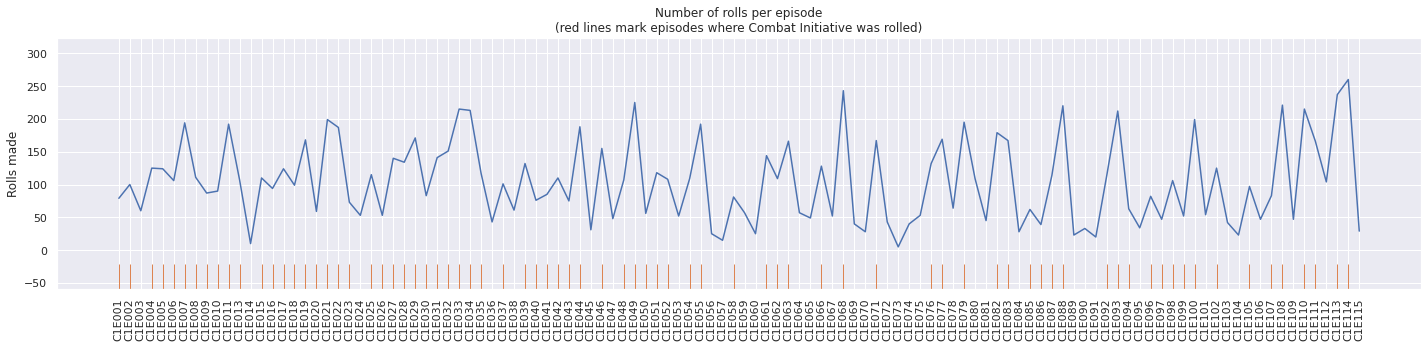

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=rolls_by_ep.sort_index(), ax=ax)
sns.rugplot(with_initiative, height=0.1, ax=ax)
plt.title('Number of rolls per episode\n'
          '(red lines mark episodes where Combat Initiative was rolled)'
)
plt.ylabel('Rolls made')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('action.png')
plt.show()

All the spikes on the graph are combat episodes; the lowest points correspond to talking/shopping episodes. I suppose, they should be interspersed for pacing reasons.

# d20 rolls

In Dungeons and Dragons, d20 (20-sided die) is the most utilized of the dice. It is used to determine whether some action of a character is successful, like whether the character noticed a stealthed enemy, or is able to hit the enemy, or whether he has access to some additional knowledge required to move the story. Usually, you roll a d20, add a bonus according to your character sheet, and check if the sum is greater or equal (success) or lower (failure) than the Difficulty Class (DC) for the skill check. There are two special roll values: 1 is an automatic failure and 20 is an automatic success (regardless of the bonuses and the DC).

## Preparing the dataframe

I'm only interested in d20 rolls made by the main cast of the show. Since Laura and Sam both roll for two characters, I am adding a column with players' names. I'm also filtering out invalid values seen in Natural Value column (anything outside of 1-20 and 'Unknown' is unacceptable).

In [ ]:
# Characters of the main cast:
CHAR_LIST = ["Grog", "Keyleth", "Percy", "Pike", "Scanlan",
             "Taryon", "Tiberius", "Trinket", "Vax'ildan", "Vex'ahlia",
             ]

# Type of Roll to filter out:
NON_D20_TYPES = [
  'Beard Check', 'Bless', 'Cutting Words', 'Damage', 'Determine Effect', 
  'Divine Intervention', 'Gambit of Ord', 'Healing', "Heroes' Feast",
  'Inspiration', 'Sleep Arrow', 'Missile Snare', 'Other', 'Parry', 'Percentile',
  'Potion Duration', 'Recharge', 'Second Wind',  
]

# Weird values in Natural Value column:
NATVAL_ERRS = [
  '0', '-1', '-4',
  '21', '22', '23', '24', '25', '26',
]

d20rolls = df[
   # Exclude weird values in Natural Value           
   ~df['Natural Value'].isin(NATVAL_ERRS)
   # Exclude non-d20 rolls 
   & ~df['Type of Roll'].isin(NON_D20_TYPES)
   # Filter for regular players' characters
   & df['Character'].isin(CHAR_LIST)
].copy()

## A note on disregarded rolls

There are a number of modifications a player can make to a d20 roll. The ones I have to pay attention the most are those that allow the player to reroll the die, because the players often tell only the final number disregarding the other one. Those modifications are:
* the character has advantage &mdash; the player rolls twice, picks the **higher** number;
* the character has disadvantage &mdash; the player rolls twice, picks the **lower** number;
* [Lucky](http://dnd5e.wikidot.com/feat:lucky) feature of a character:
  > You have 3 luck points. Whenever you make an attack roll, an ability check, or a saving throw, you can spend one luck point to roll an additional d20. You can choose to spend one of your luck points after you roll the die, but before the outcome is determined. You choose which of the d20s is used for the attack roll, ability check, or saving throw. <br><br>
You regain your expended luck points when you finish a long rest.
* [Indomitable](https://roll20.net/compendium/dnd5e/Fighter#toc_16) ability of the Fighter class:
  > Beginning at 9th level, you can reroll a saving throw that you fail. If you do so, you must use the new roll, and you can't use this feature again until you finish a Long Rest.

  One of the players in *Critical Role* calls this ability *Resolve* (I don't know why).

The reason I need to keep track of these rolls, is that they are recorded but marked as *Unknown*. Since the lower numbers are disregarded more often (empirically; I'll show later), this introduces bias into the known rolls.

In the *All Rolls - Tal'Dorei* table, all these rolls are marked in the *Notes* column. Usually one note says "With ..." and the counterpart says "Disregarded due to ...". For example, "With advantage" and "Disregarded due to advantage" in Persuasion rolls made by Tiberius (shown below).

In [ ]:
d20rolls.head()

,Episode,Time,Character,Type of Roll,Total Value,Natural Value,Crit?,Damage,# Kills,Notes
0,C1E001,0:37:53,Vex'ahlia,Intelligence,20,18,N,NaN,NaN,FIRST ROLL OMG
1,C1E001,0:41:48,Grog,Persuasion,19,18,N,NaN,NaN,NaN
2,C1E001,0:43:25,Keyleth,Persuasion,2,2,N,NaN,NaN,NaN
3,C1E001,0:46:35,Tiberius,Persuasion,12,3,N,NaN,NaN,Disregarded due to advantage
4,C1E001,0:46:35,Tiberius,Persuasion,27,18,N,NaN,NaN,With advantage


In [ ]:
is_disregarded = d20rolls['Notes'].str.contains('isregard').fillna(False)

## Relationship between **Total Value** and **Natural Value**

               Total Value  Natural Value
Total Value       1.000000       0.670177
Natural Value     0.670177       1.000000



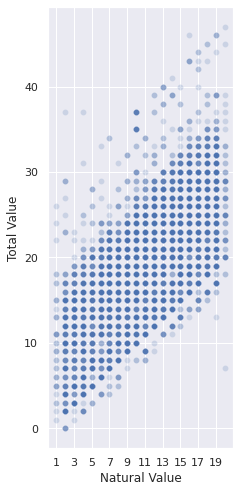

In [ ]:
nat_and_total = (
    d20rolls.loc[
        (d20rolls['Natural Value'] != 'Unknown')
        & ~d20rolls['Total Value'].isin(
            [
             'Unknown'
             , 'Nat1'
             , 'Nat20'
             , 'Nat1?'
             , 'Nat2'
             , '>20'
             , 'Nat3'
             , 'Nat19'
            ]
          )
        , ['Total Value', 'Natural Value', 'Character']
    ].astype(
             {
              'Natural Value' : np.int8
              , 'Total Value' : np.int8
             }
            )
)
print(nat_and_total.corr())
print()

fig, ax = plt.subplots(figsize=(3.5, 7))
sns.scatterplot(x='Natural Value'
                , y='Total Value'
                , data=nat_and_total
                , alpha=0.2
)
plt.xticks(np.arange(1, 21, 2))
plt.tight_layout()
plt.show()

As expected, there is quite a strong correlation between Natural Value and Total Value columns.

## Who is doing what in this game 

To make all characters equal, I'll adjust all d20 rolls by characters' presence in the game. Numbers for players' attendance are taken from [this table](https://docs.google.com/spreadsheets/d/1Zx1N0cQcd1fJadUwar7f2hJ2p61qoX7lctsVaIEa5uM/edit#gid=744793917) by CritRoleStats.

Pike's player was busy with her job and couldn't always be present, Taryon is a temporary character (replaced Scanlan for 14 episodes), Tiberius's player left the show at episode 28, Trinket is a decorative pet.

In [ ]:
attendance = pd.Series({'Grog' : 109,
                        'Keyleth' : 112,
                        'Percy' : 111,
                        'Pike' : 54,
                        'Scanlan' : 92,
                        'Taryon' : 14,
                        'Tiberius' : 24,
                        'Trinket' : 47,
                        "Vax'ildan" : 111,
                        "Vex'ahlia" : 112
                       }
                      )
coef = 114 / attendance
coef

Grog         1.045872
Keyleth      1.017857
Percy        1.027027
Pike         2.111111
Scanlan      1.239130
Taryon       8.142857
Tiberius     4.750000
Trinket      2.425532
Vax'ildan    1.027027
Vex'ahlia    1.017857
dtype: float64

I'm making a **Character** x **Type of Roll** table. The sample of it is below.

In [ ]:
rolls_by_char = (
    pd.crosstab(*d20rolls.loc[~is_disregarded
                              , ['Character'
                                 , 'Type of Roll'
                                ]
                             ].values.T
                , rownames=['Character']
                , colnames=['Type of Roll']
               ).mul(coef, axis=0)
                .round()
                .astype(np.uint16)
)
rolls_by_char.iloc[:, :10]

Type of Roll,Acrobatics,Alchemy,Animal Handling,Arcana,Assist,Athletics,Attack,Blacksmith Tools,Charisma,Charisma Save
Character,,,,,,,,,,
Grog,13,0,1,5,0,127,557,8,1,7
Keyleth,11,3,3,12,0,38,83,0,1,4
Percy,20,0,1,9,1,21,597,0,2,1
Pike,21,0,2,8,0,17,122,0,0,0
Scanlan,19,0,0,50,0,31,72,0,25,7
Taryon,0,0,0,8,0,16,73,0,0,0
Tiberius,24,0,33,166,0,10,171,0,19,5
Trinket,2,0,0,0,0,22,124,0,0,0
Vax'ildan,51,0,0,3,2,39,559,0,0,4


### Overview

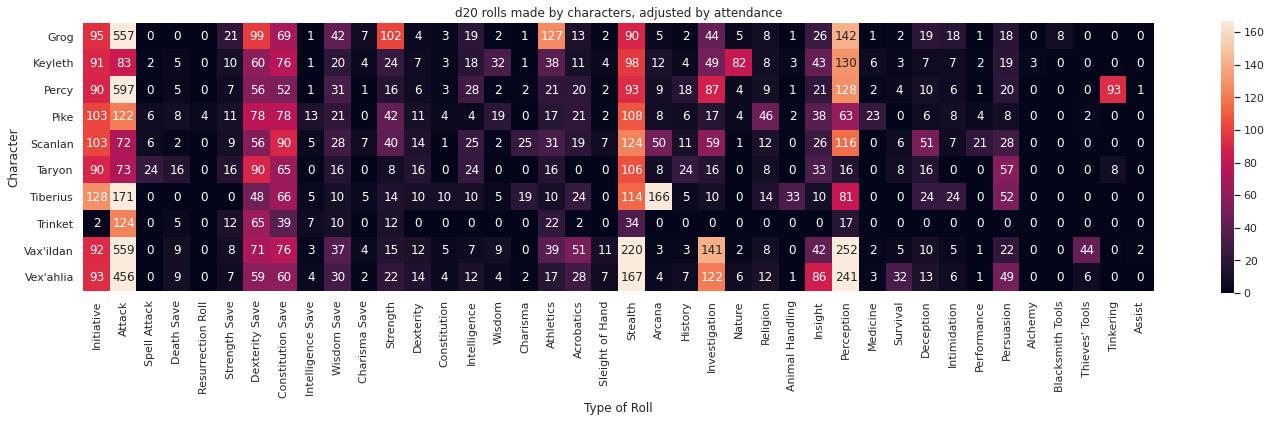

In [ ]:
plt.figure(figsize=(20, 7))

ordered_rolls = [
  'Initiative'
  , 'Attack'
  , 'Spell Attack'
  , 'Death Save'
  , 'Resurrection Roll'
  , 'Strength Save'
  , 'Dexterity Save'
  , 'Constitution Save'
  , 'Intelligence Save'
  , 'Wisdom Save'
  , 'Charisma Save'
  , 'Strength'
  , 'Dexterity'
  , 'Constitution'
  , 'Intelligence'
  , 'Wisdom'
  , 'Charisma'
  , 'Athletics'                      
  , 'Acrobatics'
  , 'Sleight of Hand'
  , 'Stealth'
  , 'Arcana'
  , 'History'
  , 'Investigation'
  , 'Nature'
  , 'Religion'
  , 'Animal Handling'
  , 'Insight'
  , 'Perception'
  , 'Medicine'
  , 'Survival'
  , 'Deception'
  , 'Intimidation'
  , 'Performance'
  , 'Persuasion'
  , 'Alchemy'
  , 'Blacksmith Tools'
  , "Thieves' Tools"
  , 'Tinkering'
  , 'Assist'
]

sns.heatmap(rolls_by_char[ordered_rolls]
            , robust=True
            , annot=True
            , fmt='d'
            , square=True
            , cbar_kws={"shrink": 0.63}
           )

plt.title('d20 rolls made by characters, adjusted by attendance')
plt.tight_layout()
# plt.show()
plt.savefig('d20rolls_heatmap.png', dpi=150)

Several things to note here:
1. Stealth and Perception checks, Dexterity and Constitution saving throws, Initiative are used a lot by almost everybody. 
1. That said, Trinket does not roll Initiative. It was decided that, in Combat, he makes his turn together with Vex'ahlia, since he is her pet.
1. The fact that Tiberius has the highest number of rolls for Initiative is an artifact of adjusting for attendance. Density of combats is higher in the beginning of the campaign (Tiberius is not present in the game since episode 28).

### Skill checks

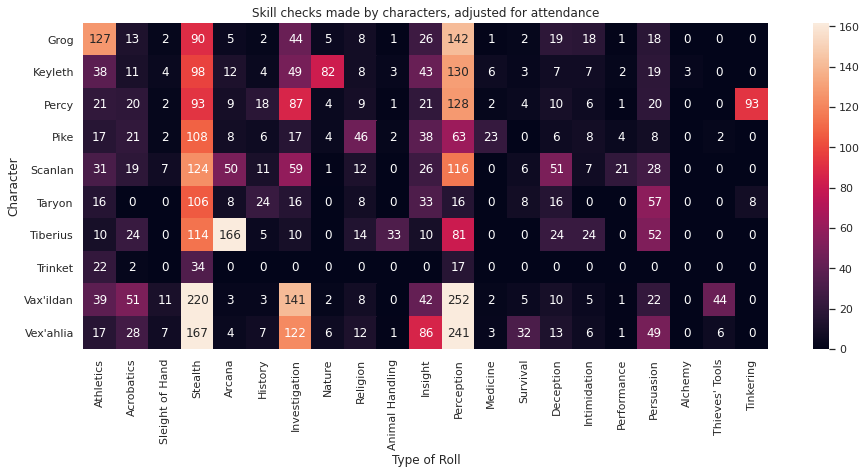

In [ ]:
skill_checks_by_char = rolls_by_char[['Athletics', 
                                      
                                      'Acrobatics',
                                      'Sleight of Hand', 
                                      'Stealth',

                                      'Arcana',
                                      'History',
                                      'Investigation',
                                      'Nature',
                                      'Religion',

                                      'Animal Handling', 
                                      'Insight', 
                                      'Perception',
                                      'Medicine',
                                      'Survival', 

                                      'Deception',
                                      'Intimidation',
                                      'Performance', 
                                      'Persuasion',

                                      'Alchemy',
                                      "Thieves' Tools",
                                      'Tinkering',
                                      ]
                                     ]

plt.figure(figsize=(16, 6))
sns.heatmap(skill_checks_by_char
            , robust=True
            , annot=True
            , fmt='d'
            , square=True)
plt.title('Skill checks made by characters, adjusted for attendance')
plt.show()

1. The twins (Vex'ahlia and Vax'ildan) use Stealth, Perception, and Investigation quite a bit more than the rest of the group. It is explained by the fact that they are the designated scouts.
1. Tiberius rolls a lot for Arcana (in this projection, at least). From Player's Handbook:
> **Arcana.** Your Intelligence (Arcana) check measures
your ability to recall lore about spells, magic items,
eldritch symbols, magical traditions, the planes of
existence, and the inhabitants of those planes.

  For some reason, Tiberius used this check as his Spell Attacks as well. Also, this could be an artifact of adjusting for his low presence in the game.
1. Grog rolls Athletics the most. He is the strongest of the characters and fights in melee, where Athletics is used for grappling and removing opponent's grapple.
1. The party does not seem to have a specialized Face character (a character who takes care of the majority of social interactions, usually the one who has high bonuses for Persuasion, Deception, and Insight checks). The one that is the closest to Face is Vex'ahlia. Scanlan lies quite a bit.

### Saving throws and straight ability checks

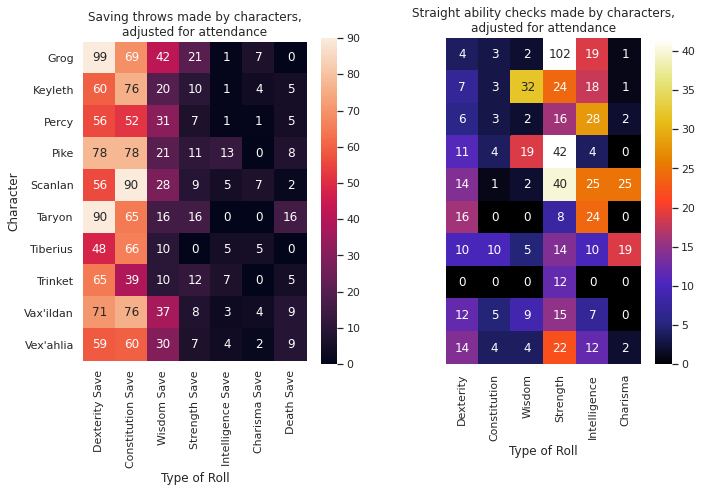

In [ ]:
saves_by_char = rolls_by_char[['Dexterity Save'
                               , 'Constitution Save'
                               , 'Wisdom Save'
                               , 'Strength Save'
                               , 'Intelligence Save'
                               , 'Charisma Save'
                               , 'Death Save'
                              ]
                             ]
ability_checks_by_char = rolls_by_char[['Dexterity'
                                        , 'Constitution'
                                        , 'Wisdom'
                                        , 'Strength'
                                        , 'Intelligence'
                                        , 'Charisma'
                                        ]]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 6), sharey=True)
axs = axs.flatten()
axs[0].set_title('Saving throws made by characters,\n'
                 'adjusted for attendance')
sns.heatmap(saves_by_char
            , robust=True
            , annot=True
            , fmt='d'
            , ax=axs[0]
            , square=True
           )

axs[1].set_title('Straight ability checks made by characters,\n'
                 'adjusted for attendance')
sns.heatmap(ability_checks_by_char
            , robust=True
            , annot=True
            , fmt='d'
            , ax=axs[1]
            , cmap=sns.color_palette('CMRmap', as_cmap=True)
            , square=True
           )
axs[1].set_ylabel('')
plt.show()

1. Dexterity and Constitution saves are the most frequent and are rolled a lot by every character. That said, there is [a thread](https://www.reddit.com/r/mattcolville/comments/bgj6p3/spells_by_saving_throw_and_effect/) on Reddit in which the author is making simple weighting of saving throws by severity of an effect being avoided. Wisdom saves can prevent some terrible things happening to a character. Difficult to say which saves are more important.
1. Intelligence and Charisma saves are rare.
1. Taryon's large number of Death Saves is an artifact of adjustment for attendance.
1. Scanlan rolls suprisingly many Strength and Intelligence checks.

# Conclusion

I've had some familiarity with the data beforehand, here are several points that are new to me:
1. By tweaking data types, memory usage can be reduced threefold.
1. In the second half of the campaign, there are more episodes without any combat.
1. The relationship between Natural Value and Total Value is not as strong as I expected: Pearson correlation coefficient is $0.67$ and I thought it would be around $0.9$. Modifier adds quite a bit of variance in the Total Value.
1. Because of his high Charisma, Scanlan is often considered group's Face, but numbers say otherwise: Vex'ahlia is more active socially.
